In [1]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
sns.set(context="paper", style="white")
import scipy.io as sio
%matplotlib inline
from mne.decoding import CSP
from mne import filter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit

## data file names and function used to extract data

In [2]:
# data filenames
trainingFileList = ['BBCIData/S14T.mat',
                    'BBCIData/S13T.mat',
                    'BBCIData/S12T.mat',
                    'BBCIData/S11T.mat',
                    'BBCIData/S10T.mat',
                    'BBCIData/S09T.mat',
                    'BBCIData/S08T.mat',
                    'BBCIData/S07T.mat',
                    'BBCIData/S06T.mat',
                    'BBCIData/S05T.mat',
                    'BBCIData/S04T.mat',
                    'BBCIData/S03T.mat',
                    'BBCIData/S02T.mat',
                    'BBCIData/S01T.mat']


validationFileList = ['BBCIData/S14E.mat',
                      'BBCIData/S13E.mat',
                      'BBCIData/S12E.mat',
                      'BBCIData/S11E.mat',
                      'BBCIData/S10E.mat',
                      'BBCIData/S09E.mat',
                      'BBCIData/S08E.mat',
                      'BBCIData/S07E.mat',
                      'BBCIData/S06E.mat',
                      'BBCIData/S05E.mat',
                      'BBCIData/S04E.mat',
                      'BBCIData/S03E.mat',
                      'BBCIData/S02E.mat',
                      'BBCIData/S01E.mat']


def extract_data(data_folder, training_fn, validation_fn):
    """
    extract data from the matfile and organize them into X and y;
    adapted from awesome_bci examples.
    note: trainin data and validation data were loaded together
    :param data_folder: where data is stored
    :param training_fn: filename
    :param validation_fn:
    :return:
    """

    # prepare data containers
    y = []
    X = []
    tmp_trainingFileList = [training_fn]
    tmp_validationFileList = [validation_fn]
    for i in range(len(tmp_trainingFileList)):
        # read file
        d1T = sio.loadmat(data_folder + tmp_trainingFileList[i])
        d1E = sio.loadmat(data_folder + tmp_validationFileList[i])

        samplingRate = d1T['data'][0][0][0][0][3][0][0]
        trialLength = 5 * samplingRate

        # run through all training runs
        for run in range(5):
            y.append(d1T['data'][0][run][0][0][2][0])  # labels
            timestamps = d1T['data'][0][run][0][0][1][0]  # timestamps
            rawData = d1T['data'][0][run][0][0][0].transpose()  # chan x data

            # parse out data based on timestamps
            for start in timestamps:
                end = start + trialLength
                X.append(rawData[:, start:end])  # 15 x 2560

        # run through all validation runs (we do not discriminate at this point)
        for run in range(3):
            y.append(d1E['data'][0][run][0][0][2][0])  # labels
            timestamps = d1E['data'][0][run][0][0][1][0]  # timestamps
            rawData = d1E['data'][0][run][0][0][0].transpose()  # chan x data

            # parse out data based on timestamps
            for start in timestamps:
                end = start + trialLength
                X.append(rawData[:, start:end])  # 15 x 2560

        del rawData
        del d1T
        del d1E

    # arrange data into numpy arrays
    # also torch expect float32 for samples
    # and int64 for labels {0,1}
    X = np.array(X).astype(np.float32)
    y = (np.array(y).flatten() - 1).astype(np.int64)
    sr = samplingRate

    return(X, y, sr)

### other parameters

In [3]:
data_folder = "./"
cue_time = 2.5  # cue starting time
signal_delay = 1.0  # take signal from 1 sec after cue onset
signal_dur = 1.5 # signal duration 
signal_st = cue_time + signal_delay
signal_et = signal_st + signal_dur

## load data from one subject

### subject 11 gives best result (> 95%), subject 4 gives the worst result (60%). 
### bad channels greatly influence the classification results. 
e.g., the 2nd channel of subject 6 is bad. After removing it, the classification accuracy increases from 50% to 90%.

In [4]:
subject_id = 6
trfn = trainingFileList[subject_id]
vlfn = validationFileList[subject_id]

In [5]:
X, y, sr = extract_data(data_folder, trfn, vlfn)
print(X.shape, y.shape, sr)

((160, 15, 2560), (160,), 512)


### visualize the raw response to check for potential outliers

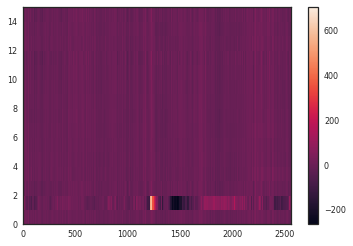

In [6]:
plt.pcolormesh(X[0]);
plt.colorbar(); plt.show()

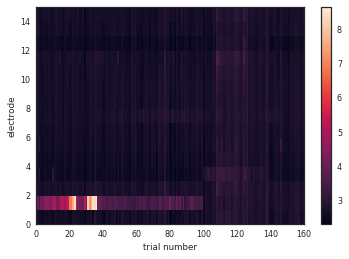

In [7]:
X_power = np.std(X, axis=-1)  # calculate the standard deviation for each electrode and each trial
plt.pcolormesh(np.log(X_power.T))
plt.xlabel("trial number"); plt.ylabel("electrode");
plt.colorbar(); plt.show()

### If the above picture is mostly black with a few bright spots, it indicates there are outliers. There may be bad electrodes or trials.

In [8]:
# electrode 1 has unnormal variations and indicate a bad electrode (electrode number start from 0)

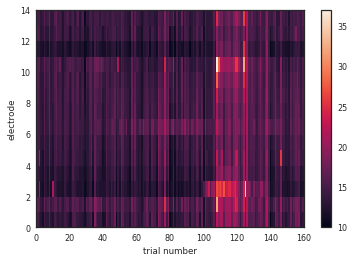

In [9]:
electrodes2del = []
# electrodes2del = [9, 11, 6]
# electrodes2del = [7], subject 3
electrodes2del = [1] # subject 6
if len(electrodes2del) != 0: 
    X = np.delete(X, electrodes2del, axis=1)
    X_power = np.std(X, axis=-1)  # calculate the standard deviation for each electrode and each trial
    plt.pcolormesh(X_power.T)
    plt.xlabel("trial number"); plt.ylabel("electrode");
    plt.colorbar(); plt.show()

## separate EEG data into different frequency bands

7 to 30 Hz band pass $\mu$ & $\beta$

band pass the filter and downsampling the signal to 100 Hz

In [10]:
low_freq = 7.0
high_freq = 30.0
down_ratio = 5.0

In [11]:
filtered_X = filter.filter_data(np.asarray(X, dtype=np.float64), sr, 
                                l_freq=low_freq, h_freq=high_freq, fir_design="firwin")
filtered_X = filter.resample(filtered_X, down=down_ratio)

Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 845 samples (1.650 sec) selected


## use CSP & LDA for decoding overall view

use the EEG response from 3.5 to 4.5 seconds for training

In [12]:
st_idx, et_idx = int(signal_st * sr / down_ratio), int(signal_et * sr / down_ratio) # only use data after 3.5 seconds
csp = CSP(n_components=6, reg=0.001, log=None, norm_trace=False, transform_into="csp_space")
csp = CSP(n_components=6, reg=0.001, log=None, norm_trace=False, transform_into="average_power")
tf_X = csp.fit_transform(filtered_X[:, :, st_idx:et_idx], y)

In [13]:
clf = LinearDiscriminantAnalysis()
mappings = clf.fit_transform(tf_X, y)
est_y = clf.predict(tf_X)

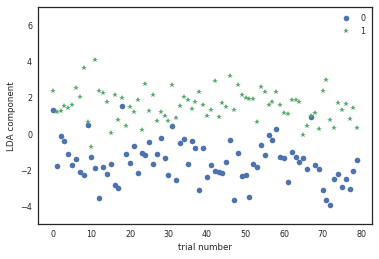

0.95


In [14]:
plt.plot(mappings[y==0], "o")
plt.plot(mappings[y==1], "*")
plt.legend(["0", "1"]);
plt.ylim(-5, 7); plt.xlabel("trial number"); plt.ylabel("LDA component")
plt.show()
print(np.sum(est_y == y) * 1.0 / len(y))

## use cross validation to measure the classification accuracy

In [15]:
def classification_acc(X, y, signal_dur=1.0, signal_delay=1.0, num_splits=10):
    # get the index in which data are used for training and testing: 1 seconds after cue onset
    signal_st = cue_time + signal_delay
    signal_et = signal_st + signal_dur
    st_idx, et_idx = int(signal_st * sr / down_ratio), int(signal_et * sr / down_ratio)
    # accuracy list
    acc_list = []
    rs = ShuffleSplit(n_splits=num_splits, test_size=0.2, random_state=7) # split the data
#     pdb.set_trace()
    for train_idx, test_idx in rs.split(X):
        # get training and testing data
        tr_X, tr_y = X[train_idx], y[train_idx]
        test_X, test_y = X[test_idx], y[test_idx]
        # train CSP based on the train data, transform the test data using the CSP from training data
        csp = CSP(n_components=6, reg=0.001, log=None, norm_trace=False, transform_into="average_power")
        train_tf_X = csp.fit_transform(tr_X[:, :, st_idx:et_idx], tr_y)
        test_tf_X = csp.transform(test_X[:, :, st_idx:et_idx])
        # train the LDA on the train data
        clf = LinearDiscriminantAnalysis()
        clf.fit(train_tf_X, tr_y)
        est_y = clf.predict(test_tf_X)
        acc = np.sum(est_y == test_y) * 1.0 / len(test_y)
        acc_list.append(acc)
    return(np.mean(acc_list), acc_list)

In [16]:
avg_acc, acc_list = classification_acc(filtered_X, y, signal_dur=1.5, num_splits=10)
print("Average classification accuracy on testing set is: %f" % (avg_acc))

Average classification accuracy on testing set is: 0.906250
